In [1]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path: sys.path.append("..")

# Segmentation and boundary-box regression

TODO: 
* Load model
* Plot intensity distribution
* Evaluate a good threshold (Weakly Supervised Deep Learning for Segmentationof Remote Sensing Imagery)

Some help:
https://stackoverflow.com/questions/64617205/merging-each-instance-mask-back-to-the-original-image-python
https://stackoverflow.com/questions/61383095/create-mask-or-boundary-from-each-other-in-python3

In [2]:
from src.segmentation.roi import RoIAlign
from src.utils.preprocess import tensor2numpy, image2axial,mask_threshold
from src.utils.utils import split_custom_filename
from src.segmentation import cam
from src.classifier.agent import load_trainer
from src.segmentation.cam import CAMS
from src.segmentation import segmentation
import nibabel as nib


import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt

In [3]:
trainer, dataset, model = load_trainer('resnet50', checkpoint_path="/logs/tb/resnet50/version_2/checkpoints/checkpoint.ckpt");

Loading model from /home/stud1/f/fremar16/Master_thesis/logs/tb/resnet50/version_2/checkpoints/checkpoint.ckpt (checkpoint)..
Architecture [ResNet] was created
***Defined hyperparameters:***
"arch":                {'name': 'resnet50', 'args': {}}
"callbacks":           ['litprogressbar', 'modelcheckpoints', 'metriccallback']
"class_weights":       None
"hp_metrics":          ['loss/train', 'loss/val', 'accuracy/val', 'auc/val', 'specificity/val', 'sensitivity/val']
"kfold":               {'enable': False, 'folds': 10}
"loss":                CrossEntropyLoss
"loss_weight_balance": None
"optimizer":           {'type': 'Adam', 'args': {'lr': 0.0002, 'weight_decay': 1e-05, 'amsgrad': False}}
Dataset sizes - Training: 421 Validation: 47


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.


In [4]:
filename= '../data/SPM_categorised/AIH/CN/CN_ADNI_0443.nii'
class_label = split_custom_filename(filename,'/')[4]
tmp_image = nib.load(filename).get_fdata()
tmp = cam.CAM(CAMS.GradCAM.value, model, image2axial(tmp_image))

grid_image, grid_mask = tmp.grid_class(tmp.class_scores, 2, pad_value=0, max_num_slices=None)

/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


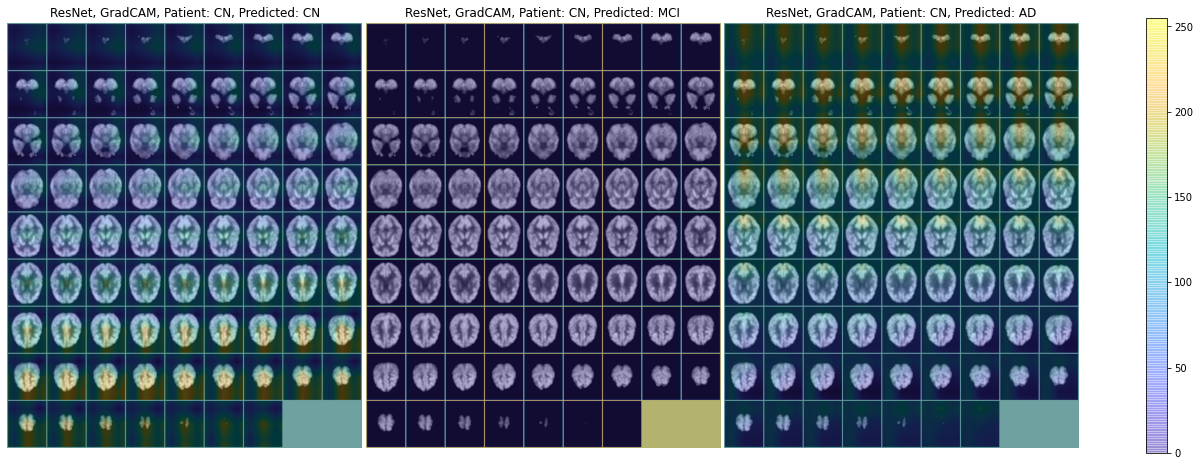

In [5]:
tmp.plot(tmp.class_scores, [0,1,2],max_num_slices=None, class_label=class_label);

# Get mask activations

In [6]:
masked_image = tmp.preprocess(tmp.activation_map(tmp.class_idx, tmp.class_scores))

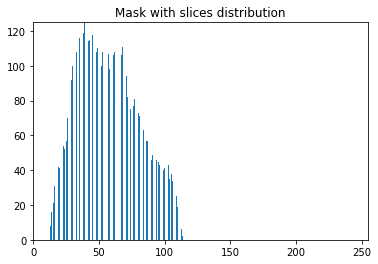

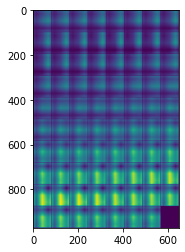

In [7]:
# Only check the distribution from each image! This looks a lot better!
segmentation.intensity_distribution(tmp.preprocess(tmp.activation_map(tmp.class_idx, tmp.class_scores))[30].flatten(),title="Mask with slices distribution")

sliced_masks = tmp.preprocess(tmp.activation_map(0, tmp.class_scores))
plt.imshow(torchvision.utils.make_grid(torch.from_numpy(sliced_masks).unsqueeze(1), nrow=8)[0])

# Fuse multiple scans

In [8]:
def extract_image_and_labels(filename):
    image = load_nifti_axial(filename)
    label = split_custom_filename(filename,'/')[4]
    return image, label

In [9]:
"""import warnings
# Get all images (maybe use the dataloader?)
from src.utils.load import load_files, load_nifti_axial



# Load all image filenames
all_image_paths = load_files('../data/SPM_categorised/AIH/')

# Setup extractor
first_image, class_label = extract_image_and_labels(all_image_paths[0])
cam_extractor = cam.CAM(CAMS.GradCAM.value, model, first_image)


# Calculate the CAM for each image
cam_storage = {
    'CN':[],
    'MCI':[],
    'AD':[]
}
image_storage = {
    'CN':[],
    'MCI':[],
    'AD':[]
}
labels = {
    'CN':0,
    'MCI':1,
    'AD':2
}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for index, filename in enumerate(all_image_paths[1:]):
        image, label = extract_image_and_labels(filename)
        cam_extractor.image = image
        cam_extractor.evaluate()

        mask = tmp.preprocess(tmp.activation_map(tmp.class_idx, tmp.class_scores))
        cam_storage[label].append(mask)
        image_storage[label].append(image)
        print(", ".join(["Index:",str(index),filename]), end='\r')
        
# Store the CAM in a list or something

# Store ref image so we can remove background. Assume the images might have small deviations in shape

# Take the average of all CAMS

# Calculate boundaries!

# Done?

"""

'import warnings\n# Get all images (maybe use the dataloader?)\nfrom src.utils.load import load_files, load_nifti_axial\n\n\n\n# Load all image filenames\nall_image_paths = load_files(\'../data/SPM_categorised/AIH/\')\n\n# Setup extractor\nfirst_image, class_label = extract_image_and_labels(all_image_paths[0])\ncam_extractor = cam.CAM(CAMS.GradCAM.value, model, first_image)\n\n\n# Calculate the CAM for each image\ncam_storage = {\n    \'CN\':[],\n    \'MCI\':[],\n    \'AD\':[]\n}\nimage_storage = {\n    \'CN\':[],\n    \'MCI\':[],\n    \'AD\':[]\n}\nlabels = {\n    \'CN\':0,\n    \'MCI\':1,\n    \'AD\':2\n}\nwith warnings.catch_warnings():\n    warnings.simplefilter("ignore")\n    for index, filename in enumerate(all_image_paths[1:]):\n        image, label = extract_image_and_labels(filename)\n        cam_extractor.image = image\n        cam_extractor.evaluate()\n\n        mask = tmp.preprocess(tmp.activation_map(tmp.class_idx, tmp.class_scores))\n        cam_storage[label].append(mask

In [10]:
"""merged_mask = np.concatenate(cam_storage['AD'])
merged_image = np.concatenate(image_storage['AD'])"""

"merged_mask = np.concatenate(cam_storage['AD'])\nmerged_image = np.concatenate(image_storage['AD'])"

In [11]:
# Note: Needs optimizations 
#features = sequential_processing(merged_image, merged_mask)

# Extract Segmentation and boundary boxes

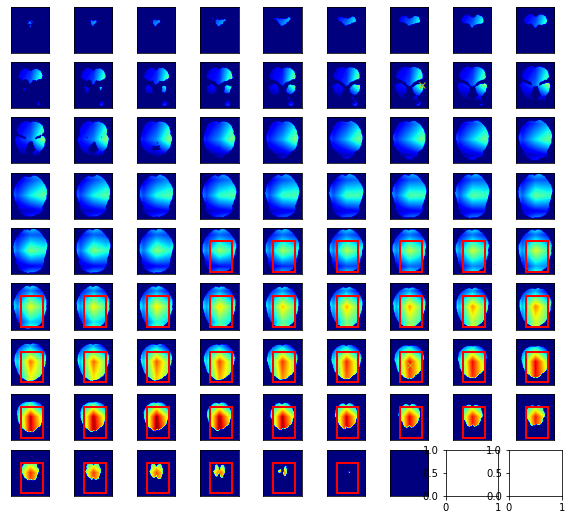

In [12]:
features = segmentation.sequential_processing(tmp.image, sliced_masks)

# RoIAlign

In [262]:
# Convert to torch but change shape from N,C,D,H,W to N,C,H,W,D. Needed by roiAlign
#image_tensor = torch.from_numpy(tmp.image).unsqueeze(0).unsqueeze(0).float().cuda()#.to('cuda:0').permute(0,1,3,4,2).#.permute(0,1,3,4,2).permute(2,1,0)

image_tensor = torch.from_numpy(tmp.image).unsqueeze(0).unsqueeze(0).float() #.permute(2,1,0)
#image_tensors = torch.vstack([image_tensor,image_tensor,image_tensor]).unsqueeze(0).float()

In [263]:
image_tensor = image_tensor.cuda()

In [264]:
image_tensor.shape

torch.Size([1, 1, 79, 95, 79])

In [192]:
#torch.from_numpy(tmp.image).unsqueeze(0).float().shape

In [193]:
# N,C,D,H,W
# 1,1,79,95,79

# x0,y0,x1,y1,z0,z1

## Test:
# y0,x0,y1,x1,z0,z1

# D:z, H: y, W:x

In [265]:
def shapie(listie):
    x0,y0,x1,y1,z0,z1 = listie
    return torch.Tensor([z0,y0,z1,y1,x0,x1])#.cuda()

In [266]:
d1 = shapie([0,0,79,79,0,79])
#d2 = shapie([20., 26., 65., 89., 39., 78.])
box_tensor = [torch.stack([d1]).cuda()]
box_tensor

[tensor([[ 0.,  0., 79., 79.,  0., 79.]], device='cuda:0')]

In [267]:
#box_tensor = torch.Tensor([[65., 47., 66., 48., 15., 16.],
#        [20., 26., 65., 89., 39., 78.]])


In [268]:
boxes = segmentation.bounding_boxes(features)
box_tensor = [torch.stack([shapie(torch.Tensor(x)) for x in boxes]).cuda()]
box_tensor[0]

tensor([[15., 47., 16., 48., 65., 66.],
        [39., 26., 78., 89., 20., 65.]], device='cuda:0')

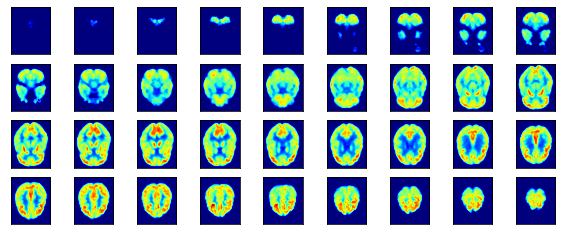

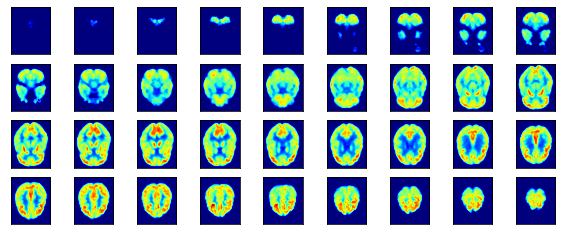

In [269]:
segmentation.display(tensor2numpy(image_tensor)[0][0])
segmentation.display(tmp.image)

In [270]:
from src.segmentation.roi_align.roi_align import RoIAlign

roialign = RoIAlign([30,30,30],spatial_scale=1.0,sampling_ratio=-1)
image_rois = roialign.forward(image_tensor,box_tensor)
new_image = tensor2numpy(image_rois)

In [271]:
#tensor2numpy(image_rois)[1].squeeze(0).transpose(2,1,0).shape

In [272]:
tensor2numpy(image_rois).shape

(2, 1, 30, 30, 30)

In [273]:
tensor2numpy(image_rois.squeeze(1)).shape

(2, 30, 30, 30)

In [274]:
new_image[0][0].min()

0.011278092

In [275]:
tensor2numpy(image_rois.squeeze(1)).shape

(2, 30, 30, 30)

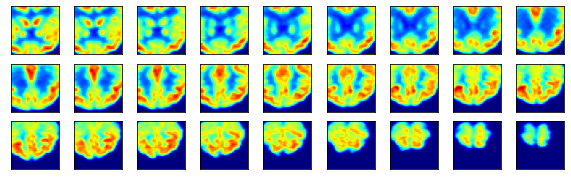

In [276]:
segmentation.display(tensor2numpy(image_rois)[1][0], step=1)

TypeError: Invalid shape (30, 30, 30) for image data

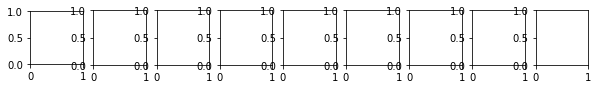

In [254]:
segmentation.display(tensor2numpy(image_rois.squeeze(1))[0],step=1) #.transpose(2,1,0)

In [ ]:
segmentation.display(tmp.image)
segmentation.display(new_image[0],step=1)
segmentation.display(tensor2numpy(image_rois)[1].squeeze(0),step=1)

In [ ]:
box_tensor.cpu()

torch.Size([2, 1, 40, 40, 40])


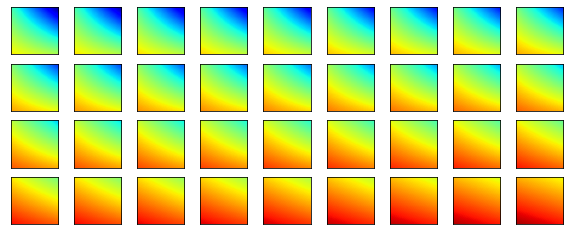

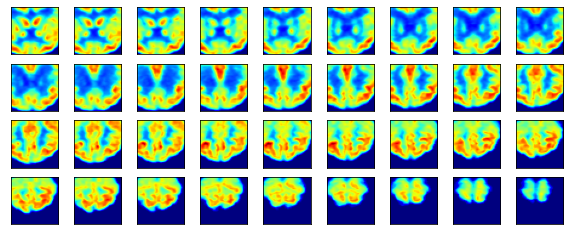

In [281]:
derp = segmentation.roi_align(tmp.image, features)
# Idea: This network only support 2D (Source? https://forum.image.sc/t/weka-3d-how-is-the-depth-of-a-roi-drawn-in-2d-defined/7315/3)
# No need to use full image and not possible with multiple scans regions..